In [49]:
# Selections

START="2011-01"
END="2011-12"

# Västra götalands län
vgr_code = "14" 

# Single municipal
selected_kom_code = "1480" # Gbg

# Or all municipals
selected_kom_code = None

# Basic stuff
import logging
import atlite
import time
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union

logging.basicConfig(level=logging.INFO)

In [54]:
# Create main cutout for 

sweden = gpd.read_file("data/geo/georef-sweden-kommun@public.geojson")

vgr = sweden.loc[sweden.lan_code.apply(lambda x: vgr_code in x)]

minx = min(vgr.geometry.apply(lambda geom: geom.bounds[0]))
miny = min(vgr.geometry.apply(lambda geom: geom.bounds[1]))
maxx = max(vgr.geometry.apply(lambda geom: geom.bounds[2]))
maxy = max(vgr.geometry.apply(lambda geom: geom.bounds[3]))

cutout = atlite.Cutout(
    path=str(f"vgr-test-{selected_kom_code}-{START}-{END}.nc"),
    module="era5",
    x=slice(minx, maxx),
    y=slice(miny, maxy),
    time=slice(START,END),
    dx=0.125,
    dy=0.125,
    dt="3h"
)

start_time = time.time()

cutout.prepare(features=['influx', 'temperature', 'wind'])

print("Execution time: %.4f minutes" % ((time.time() - start_time) / 60))


if selected_kom_code is None:
    selection = gpd.GeoDataFrame(geometry=[unary_union(vgr.geometry)], crs=vgr.crs)
else:
    selection = vgr.loc[vgr['kom_code'].isin(selected_kom_code)]

/home/celin/.local/lib/python3.10/site-packages/atlite/cutout.py:190: UserWarning: Arguments module, x, y, time, dx, dy, dt are ignored, since cutout is already built.
  warn(
INFO:atlite.data:Storing temporary files in /tmp/tmpyu9pzh3o


Execution time: 0.0002 minutes


In [55]:
# Exclude land use per solar/wind

import atlite
import xarray as xr
import matplotlib.pyplot as plt
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

# Source: https://www.uts.edu.au/oecm/renewable-resource-mapping
# (Classification mapping: https://collections.sentinel-hub.com/corine-land-cover/readme.html)

# Land-cover classes NOT included for solar areas:
EXCLUDED_SOLAR = [1,4,5,6,7,9,10,11,23,24,25,27,30,33,34,35,36,37,38,39,40,41,42,43,44] # 1.1.1,1.2.2,1.2.3,1.2.4,1.3.1,1.3.3,1.4.1,1.4.2,3.1.1,3.1.2,3.1.3,3.2.2,3.3.1,3.3.4,3.3.5,4.1.1,4.1.2,4.2.1,4.2.2,4.2.3,5.1.1,5.1.2,5.2.1,5.2.2,5.2.3
# Land-cover classes NOT included for wind energy areas:
EXCLUDED_WIND_NON_OCEAN = [1,2,3,4,5,6,7,9,10,11,15,16,17,23,24,25,27,30,31,33,34,35,36,37,38,39,40,41,42,43,44] # 1.1.1,1.1.2,1.2.1,1.2.2,1.2.3,1.2.4,1.3.1,1.3.3,1.4.1,1.4.2,2.2.1,2.2.2,2.2.3,3.1.1,3.1.2,3.1.3,3.2.2,3.3.1,3.3.2,3.3.4,3.3.5,4.1.1,4.1.2,4.2.1,4.2.2,4.2.3,5.1.1,5.1.2,5.2.1,5.2.2,5.2.3
INCLUDED_WIND_OCEAN = [44] # 5.2.3


CORINE = "data/geo/corine.tif"
solar_excluder = ExclusionContainer()
wind_onshore_excluder = ExclusionContainer()
wind_offshore_excluder = ExclusionContainer()

solar_excluder.add_raster(CORINE, codes=EXCLUDED_SOLAR)
wind_onshore_excluder.add_raster(CORINE, codes=EXCLUDED_WIND_NON_OCEAN)
wind_offshore_excluder.add_raster(CORINE, codes=INCLUDED_WIND_OCEAN, invert=True)

solar_avail = cutout.availabilitymatrix(selection, solar_excluder)
wind_onshore_avail = cutout.availabilitymatrix(selection, wind_onshore_excluder)
wind_offshore_avail = cutout.availabilitymatrix(selection, wind_offshore_excluder)

Compute availability matrix: 100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26 gridcells/s]


In [56]:
# Atlite availability results : SOLAR
cap_per_sqkm = 1.7
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = solar_avail.stack(spatial=["y", "x"]) * area * cap_per_sqkm
solar_availability = cutout.pv(
    matrix=capacity_matrix,
    panel=atlite.solarpanels.CdTe,
    orientation="latitude_optimal",
    index=selection.index,
)

# ToDo: Is this ok data? Verify...

INFO:atlite.convert:Convert and aggregate 'pv'.


In [57]:
# Atlite availability results : WIND ONSHORE
cap_per_sqkm = 1.7
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = wind_onshore_avail.stack(spatial=["y", "x"]) * area * cap_per_sqkm
wind_onshore_availability = cutout.wind(
    matrix=capacity_matrix,
    turbine = 'Vestas_V90_3MW',
    index=selection.index,
)

# ToDo: Is this ok data? Verify...

/home/celin/.local/lib/python3.10/site-packages/atlite/resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)
INFO:atlite.convert:Convert and aggregate 'wind'.


In [58]:
# Atlite availability results : WIND OFFSHORE
cap_per_sqkm = 1.7
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = wind_offshore_avail.stack(spatial=["y", "x"]) * area * cap_per_sqkm
wind_offshore_availability = cutout.wind(
    matrix=capacity_matrix,
    turbine = 'Vestas_V90_3MW',
    index=selection.index,
)

# ToDo: Is this ok data? Verify...

/home/celin/.local/lib/python3.10/site-packages/atlite/resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)
INFO:atlite.convert:Convert and aggregate 'wind'.


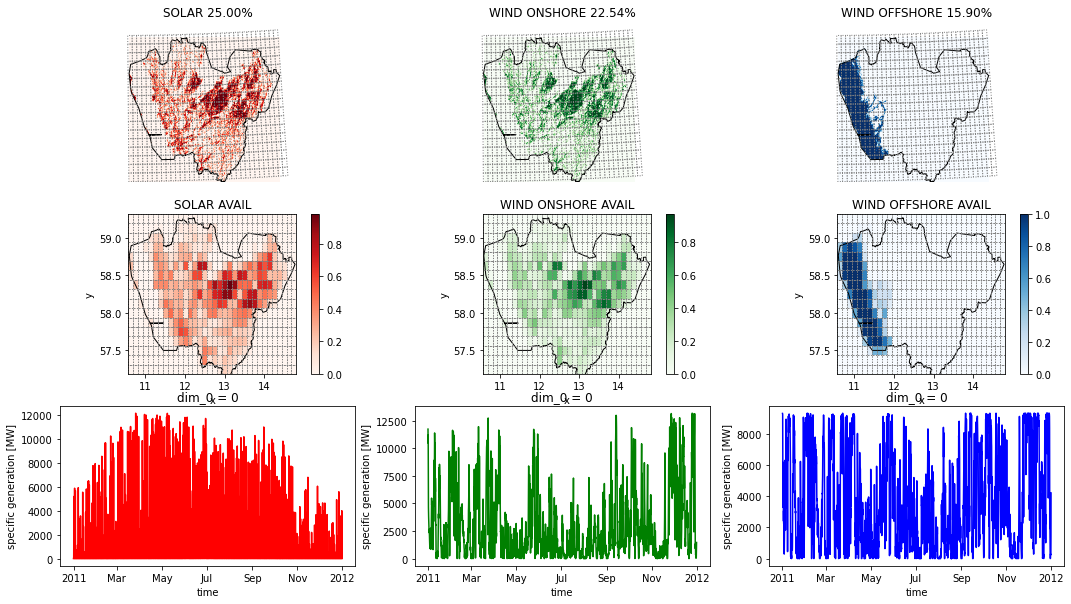

In [59]:
# Some graphs

from matplotlib.gridspec import GridSpec

crs = selection.geometry.to_crs(solar_excluder.crs)
masked, transform = solar_excluder.compute_shape_availability(crs)
solar_eligible_share = masked.sum() * solar_excluder.res**2 / crs.geometry.item().area

crs = selection.geometry.to_crs(wind_onshore_excluder.crs)
masked, transform = wind_onshore_excluder.compute_shape_availability(crs)
wind_onshore_eligible_share = masked.sum() * wind_onshore_excluder.res**2 / crs.geometry.item().area

crs = selection.geometry.to_crs(wind_offshore_excluder.crs)
masked, transform = wind_offshore_excluder.compute_shape_availability(crs)
wind_offshore_eligible_share = masked.sum() * wind_offshore_excluder.res**2 / crs.geometry.item().area

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])

# Solar
solar_excluder.plot_shape_availability(selection, ax=ax1, show_kwargs = { "cmap": "Reds" })
cutout.grid.to_crs(solar_excluder.crs).plot(edgecolor="grey", color="None", ax=ax1, ls=":")
ax1.set_title(f"SOLAR {solar_eligible_share:.2%}")
ax1.axis("off");

# Wind (onshore)
wind_onshore_excluder.plot_shape_availability(selection, ax=ax2, show_kwargs = { "cmap": "Greens" })
cutout.grid.to_crs(wind_onshore_excluder.crs).plot(edgecolor="grey", color="None", ax=ax2, ls=":")
ax2.set_title(f"WIND ONSHORE {wind_onshore_eligible_share:.2%}")
ax2.axis("off");

# Wind (offshore)
wind_offshore_excluder.plot_shape_availability(selection, ax=ax3, show_kwargs = { "cmap": "Blues" })
cutout.grid.to_crs(wind_offshore_excluder.crs).plot(edgecolor="grey", color="None", ax=ax3, ls=":")
ax3.set_title(f"WIND OFFSHORE {wind_offshore_eligible_share:.2%}")
ax3.axis("off");


# Solar avail
solar_avail.sel(dim_0=0).plot(cmap="Reds", ax=ax4)
selection.plot(ax=ax4, edgecolor="k", color="None")
cutout.grid.plot(ax=ax4, color="None", edgecolor="grey", ls=":")
ax4.set_title("SOLAR AVAIL")

# Wind (onshore) avail
wind_onshore_avail.sel(dim_0=0).plot(cmap="Greens", ax=ax5)
selection.plot(ax=ax5, edgecolor="k", color="None")
cutout.grid.plot(ax=ax5, color="None", edgecolor="grey", ls=":")
ax5.set_title("WIND ONSHORE AVAIL")

# Wind (offshore) avail
wind_offshore_avail.sel(dim_0=0).plot(cmap="Blues", ax=ax6)
selection.plot(ax=ax6, edgecolor="k", color="None")
cutout.grid.plot(ax=ax6, color="None", edgecolor="grey", ls=":")
ax6.set_title("WIND OFFSHORE AVAIL")

# Capacity
solar_availability.plot(color="Red", ax=ax7)
wind_onshore_availability.plot(color="Green", ax=ax8)
wind_offshore_availability.plot(color="Blue", ax=ax9)

In [68]:
# PyPSA VGR

import pypsa
import numpy as np
import pandas as pd
from datetime import datetime


"""
The network:

A central bus that connects a solar generator, an onshore and an offshore wind generator, a battery, and a load.

"""

# Create the timeseries index
index = pd.date_range("2011-01-01 00:00", "2011-12-31 21:00", freq="3h")

# Cost assumptions (example values, should be refined)
# TODO: get realistic figures here and in SEK or kSEK
cost_per_mw_solar = 1000  # in $/MW
cost_per_mw_wind = 1200  # in $/MW
cost_per_mwh_storage = 500  # in $/MWh

# Initialize the network
network = pypsa.Network()
network.set_snapshots(index)

# Add the buses
network.add("Bus", "Main bus")

# Add load
## Load the demand data (it comes in a format of peak demand per each hour and per month and per weekend/weekday and per h3 hexagon)
demand_data = pd.read_csv('data/demand/demand_vgr_2025.csv')
demand_year = demand_data['Year'][0]
demand_data.drop(columns=['Unnamed: 0', 'Year'], inplace=True)
demand_data['Timestamp'] = pd.to_datetime(demand_data['Timestamp'], format='%Y-%m-%d %H:%M:%S')
demand_data.set_index('Timestamp', inplace=True)

## Aggregate by summing over all the hexagons and resampling from 1h to 3h intervals
grouped_demand_data = demand_data.groupby([demand_data.index, 'Daytype']).sum()['Demand (MW)'].groupby([pd.Grouper(freq='3h', level=0), 'Daytype']).mean()

## Function that returns the appropriate demand for a given day
def select_demand(index):
    return grouped_demand_data[index.replace(year=demand_year ,day=1),'weekday' if index.weekday() < 5 else 'weekend']

## Build a load profile
target_percentage = 0.3 # This is the percentage of the demand that we want to fulfill
load_profile = [target_percentage*select_demand(i) for i in index]

## Finally add the load to the network
network.add("Load", "Desired load", bus="Main bus", p_set=load_profile)

# Add generation
# TODO: replace with data from atlite
#solar_availability = np.random.rand(len(index))
#wind_onshore_availability = np.random.rand(len(index))
#wind_offshore_availability = np.random.rand(len(index))

network.add("Generator", "Solar park", bus="Main bus", p_nom_extendable=True, 
            capital_cost=cost_per_mw_solar, p_max_pu=solar_availability.values.flatten())

network.add("Generator", "Wind farm onshore", bus="Main bus", p_nom_extendable=True, 
            capital_cost=cost_per_mw_wind, p_max_pu=wind_onshore_availability.values.flatten())

network.add("Generator", "Wind farm offshore", bus="Main bus", p_nom_extendable=True, 
            capital_cost=cost_per_mw_wind, p_max_pu=wind_offshore_availability.values.flatten())

# Add storage
network.add("StorageUnit", "Battery", bus="Main bus", p_nom_extendable=True,
            capital_cost=cost_per_mwh_storage)

# Define the objective function (minimize cost)
network.optimize(network.snapshots, solver_name='cbc')

# Output results
print("Optimal size of Solar Park: {:.2f} MW".format(network.generators.p_nom_opt["Solar park"]))
print("Optimal size of Wind Farm (onshore): {:.2f} MW".format(network.generators.p_nom_opt["Wind farm onshore"]))
print("Optimal size of Wind Farm (offshore): {:.2f} MW".format(network.generators.p_nom_opt["Wind farm offshore"]))
print("Optimal size of Battery Storage: {:.2f} MWh".format(network.storage_units.p_nom_opt["Battery"]))


INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 160.43it/s]
INFO:linopy.io: Writing time: 0.26s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-xc5biqj8.lp -solve -solu /tmp/linopy-solve-rtud2235.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 21573 (-19311) rows, 15782 (-1742) columns and 56025 (-21144) elements
Perturbing problem by 0.001% of 10356.207 - largest nonzero change 0.008206777 ( 0.0016377381%) - largest zero change 0.008206438
0  Obj 1675666.5 Primal inf 733677.87 (2909)
332  Obj 1675700.9 Primal inf 643521.98 (2902)
664  Obj 1675718.8 Primal inf 551841.54 (2898)
996  Obj 1895689.7 Primal inf 461563.19 (2888)
1328  Obj 1895705.5 Primal inf 38597

Optimal size of Solar Park: 0.90 MW
Optimal size of Wind Farm (onshore): 10.05 MW
Optimal size of Wind Farm (offshore): 4.40 MW
Optimal size of Battery Storage: 3791.22 MWh
